In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Variation of Maja's model
# Taken from (Simson Garfinkel, John M. Abowd, Christian Martindale. Understanding Database Reconstruction Attacks on Public Data. Communications of the ACM, March 2019, Vol. 62 No. 3, Pages 46-53. DOI: 10.1145/3287287)

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5*2 # (age, gender)
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)] # 0-4 age vars, 5-9 sex vars
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]]))
g.add(sat.addition_does_not_overflow([x[5], x[6], x[7], x[8], x[9]]))
for i in range(5):
    g.add(sat.multi_does_not_overflow([x[i],x[i+5]])) # this is in case of multiplication

# these are binary (obviously only for the purpose of the example)
# FEMALE = 0
# MALE = 1
for i in range(5,10):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],1))


# establish an order to set the median
g.add(ULE(0,x[0]))
g.add(ULE(x[0],x[1]))
g.add(ULE(x[1],x[2]))
g.add(ULE(x[2],x[3]))
g.add(ULE(x[3],x[4]))
g.add(ULE(x[4],125))

g.add(x[2] == 30) # median

g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) # average age

g.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

g.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males

# NOTE: we might need to set an overflow constraint for the last sum.


As a sanity check, we verify that the SMT problem has a solution

In [3]:
# sanity check (optional)
solve(g)

[x80 = False,
 x04 = False,
 x06 = False,
 x03 = False,
 x51 = False,
 x45 = False,
 x11 = True,
 x43 = True,
 x40 = False,
 x34 = True,
 x13 = True,
 x30 = False,
 x52 = False,
 x10 = False,
 x32 = False,
 x41 = False,
 x44 = False,
 x01 = False,
 x33 = True,
 x35 = True,
 x42 = False,
 x70 = True,
 x36 = False,
 x90 = True,
 x60 = True,
 x12 = True,
 x02 = False,
 x46 = True,
 x31 = True,
 x14 = True,
 x86 = False,
 x17 = False,
 x75 = False,
 x64 = False,
 x67 = False,
 x96 = False,
 x92 = False,
 x87 = False,
 x82 = False,
 x73 = False,
 x66 = False,
 x65 = False,
 x62 = False,
 x77 = False,
 x81 = False,
 x37 = False,
 x16 = False,
 x63 = False,
 x94 = False,
 x76 = False,
 x84 = False,
 x85 = False,
 x71 = False,
 x83 = False,
 x95 = False,
 x91 = False,
 x15 = False,
 x97 = False,
 x74 = False,
 x61 = False,
 x93 = False,
 x72 = False,
 x50 = False,
 x57 = False,
 x56 = False,
 x53 = False,
 x55 = False,
 x07 = False,
 x54 = False,
 x05 = False,
 x00 = False,
 x1 = 30,
 x4 = 72,

In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	1567/1567/0
independent support size:  	0
clauses (all/long/binary/unit): 7393/5910/1424/59
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	108863 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	108863 MB

Sample #1 of 159 is already a complete assignment.  Continuing...
Completing sample #2 of 159 which has 63 variables unset and 10 samples.
Completing sample #3 of 159 which has 25 variables unset and 96 samples.
Completing sample #4 of 159 which has 51 variables unset and 41 samples.
Completing sample #5 of 159 which 

In [5]:
num_samples   = 10000
sat.execute_spur(f'{input_dir}/{input_file}',num_samples=num_samples)

Using default filename: "spur_input/samples_Database1.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/Database1.cnf
Output File: spur_input/samples_Database1.txt

Preprocessing ... DONE
variables (all/used/free): 	1605/1605/0
independent support size:  	0
clauses (all/long/binary/unit): 7507/5948/1500/59
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1520 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1520 MB

Sample #1 of 136 is already a complete assignment.  Continuing...
Completing sample #2 of 136 which has 57 variables unset and 42 samples.
Completing sample #3 of 136 which has 47 variables unset and 11 samples.
Completing sample #4 of 136 which has 69 variables unset and 38 samples.
Completing sample #5 of 136 which has 29 variables unset and 12 samples.
Completing sample #6 of 136 which has 25 variables unset and 122 samples.
Completing sample #7 of 136 which has 57 variables unset and 13 samples.
Completing sample #8 of 136 which has 123 variables unset and 49 samples.
Completing sample #9 of 136 which has 105 variables unset and 37 samples.
Completing sample #10 of 136 which has 86 variables unset and 35 samples.
Completing sample #11 of 136 which has 29 variables unset and 16 sample

Completing sample #39 of 136 which has 26 variables unset and 50 samples.
Completing sample #40 of 136 which has 89 variables unset and 27 samples.
Completing sample #41 of 136 which has 73 variables unset and 19 samples.
Completing sample #42 of 136 which has 36 variables unset and 9 samples.
Completing sample #43 of 136 which has 54 variables unset and 12 samples.
Completing sample #44 of 136 which has 50 variables unset and 21 samples.
Completing sample #45 of 136 which has 63 variables unset and 19 samples.
Completing sample #46 of 136 which has 50 variables unset and 15 samples.
Completing sample #47 of 136 which has 27 variables unset and 12 samples.
Completing sample #48 of 136 which has 108 variables unset and 9 samples.
Completing sample #49 of 136 which has 75 variables unset and 18 samples.
Completing sample #50 of 136 which has 56 variables unset and 32 samples.
Completing sample #51 of 136 which has 117 variables unset and 37 samples.
Completing sample #52 of 136 which has

Completing sample #76 of 136 which has 64 variables unset and 20 samples.
Completing sample #77 of 136 which has 54 variables unset and 33 samples.
Completing sample #78 of 136 which has 54 variables unset and 10 samples.
Completing sample #79 of 136 which has 41 variables unset and 10 samples.
Completing sample #80 of 136 which has 33 variables unset and 64 samples.
Completing sample #81 of 136 which has 77 variables unset and 26 samples.
Completing sample #82 of 136 which has 77 variables unset and 20 samples.
Completing sample #83 of 136 which has 86 variables unset and 26 samples.
Completing sample #84 of 136 which has 43 variables unset and 66 samples.
Completing sample #85 of 136 which has 76 variables unset and 25 samples.
Completing sample #86 of 136 which has 36 variables unset and 14 samples.
Completing sample #87 of 136 which has 76 variables unset and 13 samples.
Completing sample #88 of 136 which has 101 variables unset and 18 samples.
Completing sample #89 of 136 which ha

Completing sample #116 of 136 which has 50 variables unset and 22 samples.
Completing sample #117 of 136 which has 67 variables unset and 14 samples.
Completing sample #118 of 136 which has 113 variables unset and 24 samples.
Completing sample #119 of 136 which has 91 variables unset and 13 samples.
Completing sample #120 of 136 which has 18 variables unset and 8 samples.
Completing sample #121 of 136 which has 61 variables unset and 72 samples.
Completing sample #122 of 136 which has 34 variables unset and 10 samples.
Completing sample #123 of 136 which has 90 variables unset and 16 samples.
Completing sample #124 of 136 which has 25 variables unset and 14 samples.
Completing sample #125 of 136 which has 39 variables unset and 11 samples.
Completing sample #126 of 136 which has 39 variables unset and 9 samples.
Completing sample #127 of 136 which has 18 variables unset and 10 samples.
Completing sample #128 of 136 which has 63 variables unset and 50 samples.
Completing sample #129 of 

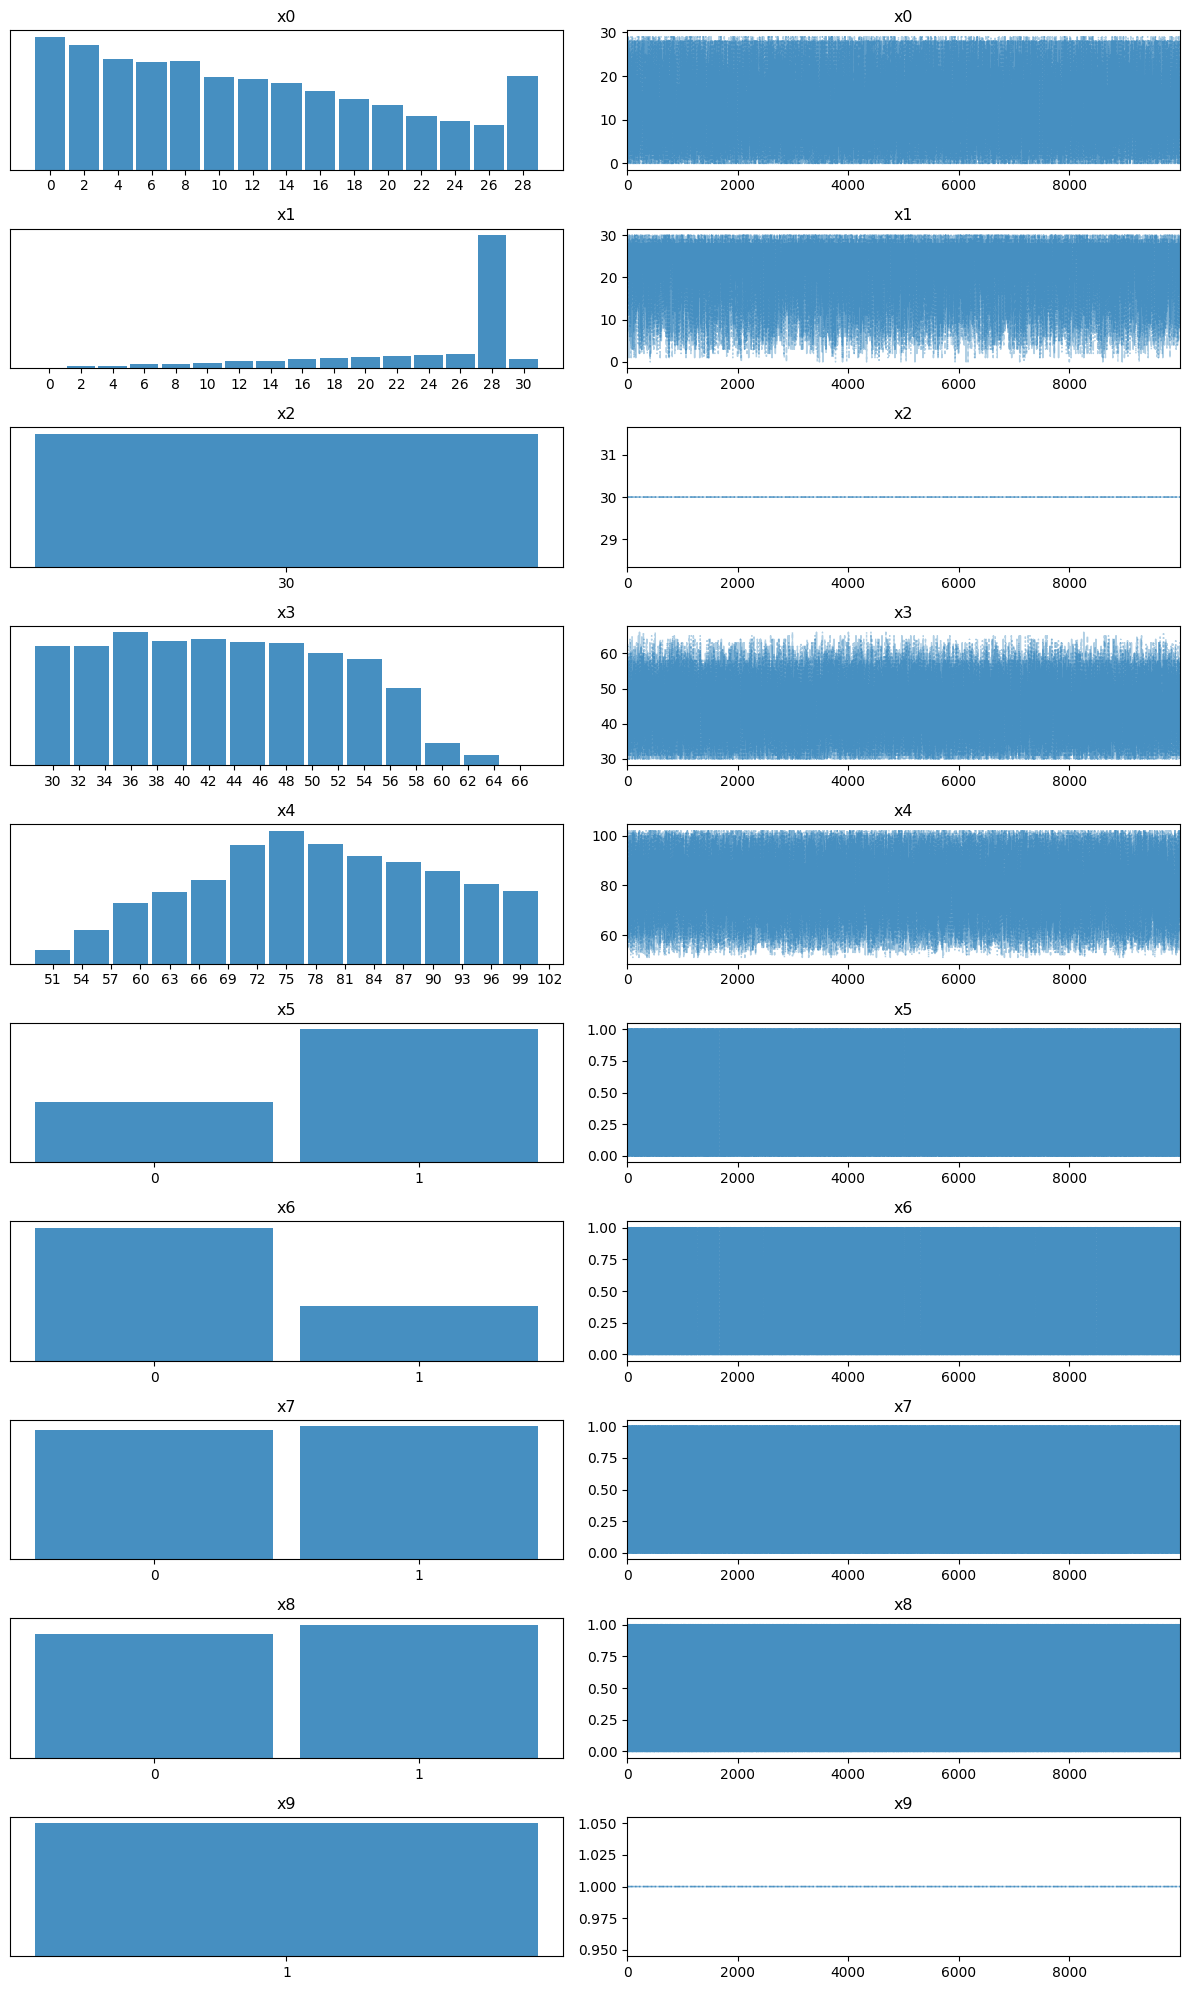

In [5]:
# Trace plot
az.plot_trace(trace);

In [6]:
# Diagnosis
az.summary(trace)

/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,12.230,8.627,0.0,28.0,0.043,0.022,40698.0,38586.0,1.0
x1,23.906,6.657,10.0,30.0,0.033,0.030,40701.0,39963.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,NaN,40000.0,40000.0,NaN
x3,44.210,8.672,30.0,58.0,0.043,0.021,39968.0,37981.0,1.0
x4,79.654,12.284,59.0,101.0,0.062,0.034,39433.0,39834.0,1.0
x5,0.686,0.464,0.0,1.0,0.002,0.001,39622.0,39622.0,1.0
x6,0.290,0.454,0.0,1.0,0.002,0.001,39791.0,39791.0,1.0
x7,0.507,0.500,0.0,1.0,0.003,0.000,39191.0,39191.0,1.0
x8,0.517,0.500,0.0,1.0,0.003,0.000,39560.0,39560.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,NaN,40000.0,40000.0,NaN


In [7]:
utils.save_trace(trace, f'db_cacm_SAT_{num_vars}_{num_bits}.nc')